***
***
# <div align="center"><font color='RED'><b>AREEBA FATAH </b></font></div>
***
# <div align="center"><font color='BLUE'><b>GENERATIVE AI</b></font></div>
***
# <div align="center"><font color='RED'><b>21I-0349</b></font></div>
***
# <div align="center"><font color='BLUE'><b>ASSIGNMENT 2</b></font></div>
***
# <div align="center"><font color='RED'><b>QUESTION 2 </b></font></div>

<br>

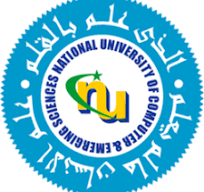<br>

# STEP 1: IMPORTING THE REQUIRED LIBRARIES

In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, ReLU, Conv2DTranspose, Activation
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

# STEP 2 : DATA LOADING AND PREPROCESSING 

## 2.1 : Data Loading
Here data is loaded from tensorflow dataset because tensorflow was comparatively faster than pytorch (tried and tested).

In [2]:
def Cifar_Loader():
    (x_train, y_train), (_, _)=cifar10.load_data()
    return x_train,y_train

## 2.2 Separating cats and dogs classes
For separating Cats and Dogs classes.

In [3]:
def Class_filterer(x_train,y_train,classes_to_keep):
    train_filter=np.isin(y_train,classes_to_keep).flatten()
    return x_train[train_filter],y_train[train_filter]

## 2.3 Normalizing Images
For normalizing images in range of -1 and 1.

In [4]:
def Image_normalizer(x_train):
    return (x_train.astype(np.float32)-127.5)/127.5

## 2.4 Resizing the images

In [5]:
def Image_resizer(x_train,size=(32,32)):
    return tf.image.resize(x_train,size)

## 2.5 Label Encoder
0 = cat <br>
1 = dog

In [6]:
def Label_encoder(y_train):
    return np.where(y_train==3,0,1)

## 2.6 Create Dataset
Shuffling and division into batches.

In [8]:
def Dataset_creator(x_train,y_train,batch_size=64):
    return tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(batch_size)

## 2.7 DATA PREPROCESSING PIPELINE FUNCTION
For calling the above functions.

In [9]:
def Data_prep(classes_to_keep=[3,5],batch_size=64):
    x_train,y_train=Cifar_Loader()
    x_train,y_train=Class_filterer(x_train,y_train,classes_to_keep)
    x_train=Image_normalizer(x_train)
    x_train=Image_resizer(x_train,(32,32))
    y_train=Label_encoder(y_train)
    train_dataset=Dataset_creator(x_train,y_train,batch_size)
    return train_dataset

In [10]:
tf.random.set_seed(42)
np.random.seed(42)
train_dataset=Data_prep()

# STEP 3: DESIGNING NETWORKS

## 3.1 GENERATOR NETWORK
- **Total Layers**: 9 layers
  - 1 Fully Connected (Dense) layer
  - 1 Reshape layer
  - 3 Batch Normalization layers
  - 3 Transposed Convolutional layers
  - 1 Activation layer

- **Activation Functions**:
  - **ReLU**: Used after the Dense layer and all Transposed Convolutional layers except for the output layer.
  - **Tanh**: Used in the output layer to map outputs to the range [-1, 1].

- **Layer Details**:
  - **Dense**: Maps input latent vector to (8, 8, 128).
  - **Reshape**: Converts the Dense output into a 3D tensor (8, 8, 128).
  - **Transposed Convolutional Layers**: Upsample the feature maps:
    - First Layer: 128 filters, kernel size 4x4, stride 2.
    - Second Layer: 64 filters, kernel size 4x4, stride 2.
    - Third Layer: 3 filters, kernel size 3x3, stride 1.


In [17]:
def GENERATOR(latent_dim=100):
    model=Sequential()
    model.add(Dense(8*8*128,input_dim=latent_dim))
    model.add(Reshape((8,8,128)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2DTranspose(64,kernel_size=4,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2DTranspose(3,kernel_size=3,padding='same'))
    model.add(Activation('tanh'))
    return model


# GENERATOR'S LOSS FUNCTION
def generator_loss(fake_score):
    return cross_entropy(tf.ones_like(fake_score),fake_score)

generator=GENERATOR()
generator.summary()
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=False)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 8192)                │         827,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 3)           │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,223,811 (4.67 MB)

 Trainable params: 1,223,171 (4.67 MB)

 Non-trainable params: 640 (2.50 KB)

## 3.2 DISCRIMINATOR INSPIRED BY SIASME NETWORK
- **Total Layers**: 7 layers
  - 2 Input layers
  - 2 Convolutional layers
  - 2 Leaky ReLU activation layers
  - 1 Flatten layer
  - 1 Dense layer

- **Activation Functions**:
  - **Leaky ReLU**: Used after each Convolutional layer with a negative slope of 0.2.
  - **Sigmoid**: Used in the output layer to produce a similarity score between 0 and 1.

- **Layer Details**:
  - **Input Layers**: Accepts real and generated images of shape (32, 32, 3).
  - **Convolutional Layers**: 
    - First Layer: 64 filters, kernel size 3x3, stride 2.
    - Second Layer: 128 filters, kernel size 3x3, stride 2.
  - **Flatten Layer**: Converts the 2D feature maps into a 1D vector for the Dense layer.

- **Loss Function**: The discriminator loss combines the binary cross-entropy losses for real and fake images to optimize its classification ability.

In [20]:
def DISCRIMINATOR():
    input_real=Input(shape=(32,32,3))
    input_generated=Input(shape=(32,32,3))

    def shared_layers(x):
        x=Conv2D(64,kernel_size=3,strides=2,padding='same')(x)
        x=LeakyReLU(0.2)(x)
        x=Conv2D(128,kernel_size=3,strides=2,padding='same')(x)
        x=LeakyReLU(0.2)(x)
        x=Flatten()(x)
        return x

    real_features=shared_layers(input_real)
    generated_features=shared_layers(input_generated)
    combined=concatenate([real_features,generated_features])
    similarity_score=Dense(1,activation='sigmoid')(combined)
    return Model([input_real,input_generated],similarity_score)

# LOSS FUNCTION FOR DISCRIMINATOR
def discriminator_loss(real_score,fake_score):
    real_loss=cross_entropy(tf.ones_like(real_score),real_score)
    fake_loss=cross_entropy(tf.zeros_like(fake_score),fake_score)
    return real_loss+fake_loss

discriminator=DISCRIMINATOR()
discriminator.summary()
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_4 (InputLayer)    │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 16, 16, 64)        │           1,792 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 16, 16, 64)        │           1,792 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 16, 16, 64)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 16, 16, 64)        │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 8, 8, 128)         │          73,856 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 8, 8, 128)         │          73,856 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 8, 8, 128)         │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 8, 8, 128)         │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 8192)              │               0 │ leaky_re_lu_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 8192)              │               0 │ leaky_re_lu_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 16384)             │               0 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │          16,385 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 167,681 (655.00 KB)

 Trainable params: 167,681 (655.00 KB)

 Non-trainable params: 0 (0.00 B)

# STEP 4 : TRAINING
1. **Train Discriminator Step**:
   - Generating fake images.
   - Computing the discriminator's output which is the similariy score.
   - Calculating the discriminator loss based similarity score.
   - Updating the discriminator's weights using backpropagation.

2. **Train Generator Step**:
   - Generating noise and producing fake images.
   - Computing the discriminator's output.
   - Calculating the generator loss based on the discriminator's feedback.
   - Updating the generator's weights using backpropagation.

3. **Main Training Loop**:
   - For each epoch, alternate between training the discriminator and generator i.e. alternative wieghts updation.
   - Visualizing images.


In [21]:
@tf.function
def TrainDiscriminatorStep(real_images):
    noise=tf.random.normal([real_images.shape[0],100])
    generated_images=generator(noise,training=True)
    with tf.GradientTape() as disc_tape:
        real_score=discriminator([real_images,real_images],training=True)
        fake_score=discriminator([real_images,generated_images],training=True)
        disc_loss=discriminator_loss(real_score,fake_score)
    gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    return disc_loss

@tf.function
def TrainGeneratorStep():
    noise=tf.random.normal([batch_size,100])
    with tf.GradientTape() as gen_tape:
        generated_images=generator(noise,training=True)
        fake_score=discriminator([generated_images,generated_images],training=True)
        gen_loss=generator_loss(fake_score)
    gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    return gen_loss

def Train(dataset,epochs):
    gen_losses=[]
    disc_losses=[]
    for epoch in range(epochs):
        for step,(real_images,_) in enumerate(dataset):
            if step%2==0:
                disc_loss=TrainDiscriminatorStep(real_images)
                disc_losses.append(disc_loss.numpy())
            else:
                gen_loss=TrainGeneratorStep()
                gen_losses.append(gen_loss.numpy())
        if epoch%100==0:
            print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
            GenerateAndShowImages(generator)
    return gen_losses,disc_losses


## 4.2 VISUALIZING RESULTS DURING TRAINING

In [22]:
def GenerateAndShowImages(generator,num_images=5):
    noise=tf.random.normal([num_images,100])
    generated_images=generator(noise)
    plt.figure(figsize=(10,2))
    for i in range(num_images):
        plt.subplot(1,num_images,i + 1)
        plt.imshow((generated_images[i]*127.5 + 127.5).numpy().astype('uint8'))
        plt.axis('off')
    plt.show()

## 4.3 TRAINING AND PRINTING LOSSES

Epoch 1, Generator Loss: 0.7918, Discriminator Loss: 1.3690


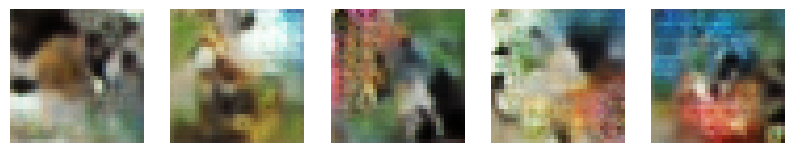

Epoch 101, Generator Loss: 0.6728, Discriminator Loss: 1.3418


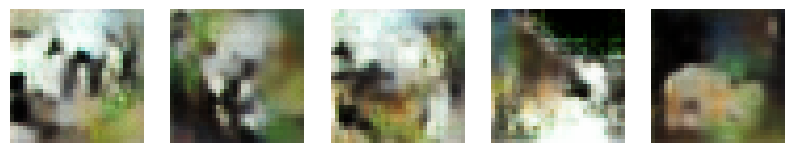

Epoch 201, Generator Loss: 0.7052, Discriminator Loss: 1.3519


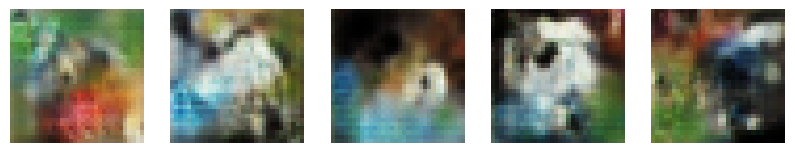

Epoch 301, Generator Loss: 0.7187, Discriminator Loss: 1.5862


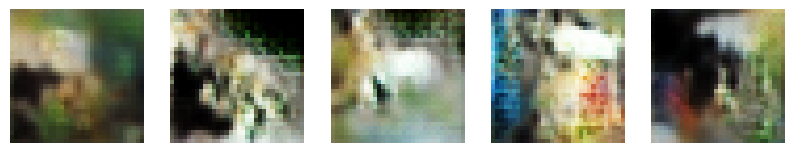

Epoch 401, Generator Loss: 0.7111, Discriminator Loss: 1.4659


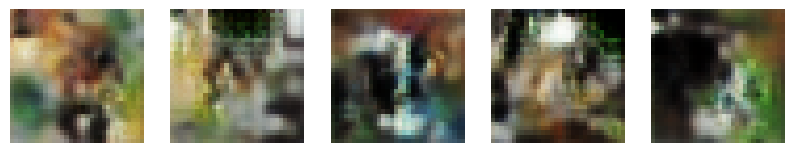

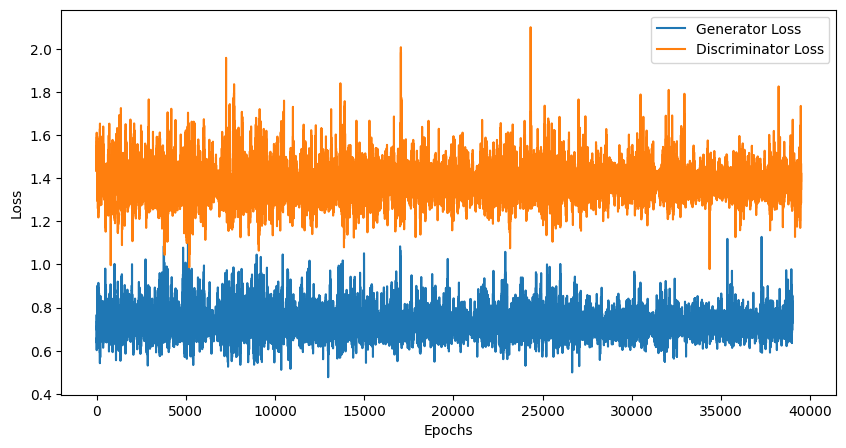

In [ ]:
gen_losses,dis_losses=train(train_dataset,epochs=500)
plt.figure(figsize=(10,5))
plt.plot(gen_losses,label='Generator Loss')
plt.plot(dis_losses,label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# STEP 5: SAVING FOR RETRAINING

In [23]:
def save_model_to_pickle(model,filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model_to_pickle(generator,'generator_model_2.pkl')
save_model_to_pickle(discriminator,'discriminator_model_2.pkl')

In [ ]:
def load_model_from_pickle(filename):
    with open(filename,'rb') as file:
        model = pickle.load(file)
    return model
generator=load_model_from_pickle('/kaggle/working/generator_model_2.pkl')
discriminator=load_model_from_pickle('/kaggle/working/discriminator_model_2.pkl')

# RESULTS

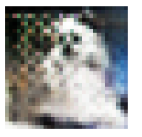
These were taken during the training process.

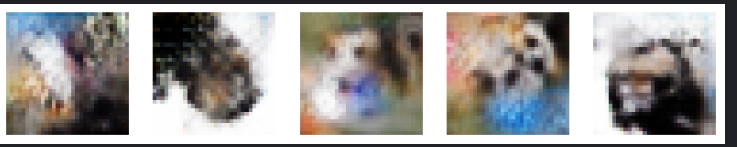

***

# <div style="text-align: center;">End</div>


***